<a href="https://colab.research.google.com/github/KhondamirRustamov/Neyron_tizimlarga-Kirish/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22ESMFold_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**ESMFold**
for more details see: [Github](https://github.com/facebookresearch/esm/tree/main/esm), [Preprint](https://www.biorxiv.org/content/10.1101/2022.07.20.500902v1)

#### **Tips and Instructions**
- click the little ▶ play icon to the left of each cell below.
- use "/" to specify chainbreaks, (eg. sequence="AAA/AAA")
- for homo-oligomeric predictions, set copies > 1
- See [experimental notebook](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/beta/ESMFold_advanced.ipynb) for more advanced options (like sampling).

#### **Colab Limitations**
- For short monomeric proteins under the length 400, consider using [ESMFold API](https://esmatlas.com/resources?action=fold) (no need for GPU, super fast!)
- On Tesla T4 (typical free colab GPU), max total length ~ 900

In [ ]:
seeq = 'GSGSGSCVKWFIYGVIAVYICYTLIVHKRYQEKEELTSSVRVTLKGVAHVDRIWDAAEYTIPTQTRDSFFVMTNIIRTENQIQKTCPEYPTAKAICSSDKSCAKGIVDVHSNGVQTGKCVHYNITHKTCEIKAWCPVQGEERPPVPAVLRSSEDFTVFIKNNIHFPTFQYTVQNISPKLNTSCKFNKVTAPLCPIFRLGDILQEAKENFSEMAVKGGIIAIEIKWDCDLDSWSYYCSPEYSFRRLDDKTRTQYPGFSIRFARHYKLPDGTEQRTLFKAYGIRFDVLVFGMGGQFKLIELFTFIGSTIAYFGLAVTIIEMCFHLYNLE'

In [ ]:
seeq[101:166]

'CAKGIVDVHSNGVQTGKCVHYNITHKTCEIKAWCPVQGEERPPVPAVLRSSEDFTVFIKNNIHFP'

In [ ]:
%%time
#@title install
#@markdown install ESMFold, OpenFold and download Params (~2min 30s)

import os, time
if not os.path.isfile("esmfold.model"):
  # download esmfold params
  os.system("apt-get install aria2 -qq")
  os.system("aria2c -q -x 16 https://colabfold.steineggerlab.workers.dev/esm/esmfold.model &")

  # install libs
  os.system("pip install -q omegaconf pytorch_lightning biopython ml_collections einops py3Dmol")
  os.system("pip install -q git+https://github.com/NVIDIA/dllogger.git")

  # install openfold
  commit = "6908936b68ae89f67755240e2f588c09ec31d4c8"
  os.system(f"pip install -q git+https://github.com/aqlaboratory/openfold.git@{commit}")

  # install esmfold
  os.system(f"pip install -q git+https://github.com/sokrypton/esm.git")

  # wait for Params to finish downloading...
  if not os.path.isfile("esmfold.model"):
    # backup source!
    os.system("aria2c -q -x 16 https://files.ipd.uw.edu/pub/esmfold/esmfold.model")
  else:
    while os.path.isfile("esmfold.model.aria2"):
      time.sleep(5)

CPU times: user 73 µs, sys: 0 ns, total: 73 µs
Wall time: 49.4 µs


In [ ]:
#@title ##import libraries

from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 1000

# Learning rate for optimizers
lr = 0.0001

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Random Seed:  999


In [ ]:
#@title ##Generator

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 5, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 5 x 5
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 5, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 10 x 10
            nn.ConvTranspose2d( ngf * 4, ngf * 2, (4,3), (1,2), (0,1), bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 10 x 20
            nn.ConvTranspose2d( ngf * 2, ngf, (4,3), (1,2), (0,1), bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 20 x 40
            nn.ConvTranspose2d( ngf, nc, (4,3), (1,2), (0,1), bias=False),
            # state size. (nc) x 20 x 80
        )

    def forward(self, input):
        return self.main(input)


device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

# Initialize BCELoss function
criterion = nn.MSELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 3), stride=(1, 2), padding=(0, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 3), stride=(1, 2), padding=(0, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 3), stride=(1, 2), padding=(0, 1), bias=False)
  )
)


(1, 1, 20, 81)


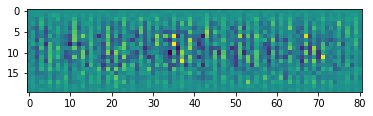

In [ ]:
%matplotlib inline
noise = torch.randn(1, nz, 1, 1, device=device)
fake = netG(noise)
plt.imshow(fake.cpu().detach().numpy()[0][0])
print(fake.cpu().detach().numpy().shape)

In [ ]:
from math import sqrt


aa = 'A R N D C E Q G H I L K M F P S T W Y V'
aminoacid_list = aa.split(' ')
a_dict={}
for i, aaa in enumerate(aminoacid_list):
  a_dict[aaa]=i


def numpy_to_seq(array, seq_len, oligomer=1):
  sequence = []
  receptor = seeq
  array = array.cpu().detach().numpy()
  for i in array:
    seq=''
    array_n = i[0]
    for i in array_n.T:
      z = np.argmax(i)
      seq+=aminoacid_list[z]
    seq = seq[:seq_len]
    seq = seq + ('/' + receptor)
    sequence.append(seq)
  return sequence


def take_loss(target_pdb_name, seq_len):
  all_loss = [take_loss1(f'{target_pdb_name}{i}.pdb') for i in range(seq_len)]
  target = [0 for i in range(seq_len)]
  return torch.tensor(target).float(), torch.tensor(all_loss).float()


def take_loss1(filename):
  with open(filename) as ifile:
      system = "".join([x for x in ifile])
  system1 = system.split("\n")
  system2 = []
  for x in system1:
    if x[:4] == 'ATOM':
      system2.append(x)
  CAS = [x for x in system2 if "CA" in x]
  CAS = [x.split(' ') for x in CAS]
  CAS = [[x for x in y if x!=''] for y in CAS ]
  CAS_A = [x for x in CAS if x[4]=='A']
  CAS_B = [x for x in CAS if x[4]=='B']
  CAS_B = CAS_B[111:116] + CAS_B[158:166] + CAS_B[271:276]
  CAS_A = np.array([np.array([float(x[6]), float(x[7]), float(x[8])]) for x in CAS_A])
  CAS_B = np.array([np.array([float(x[6]), float(x[7]), float(x[8])]) for x in CAS_B])
  loss = sum([sqrt(np.sum((CAS_A - i)**2))/CAS_A.shape[0] for i in CAS_B])/CAS_B.shape[0]
  return loss

In [ ]:
#@title ##run **ESMFold**
from string import ascii_uppercase, ascii_lowercase
import hashlib, re, os
import numpy as np
from jax.tree_util import tree_map
import matplotlib.pyplot as plt
from scipy.special import softmax

def ESM_fold(seq, id):
  def parse_output(output):
    pae = (output["aligned_confidence_probs"][0] * np.arange(64)).mean(-1) * 31
    plddt = output["plddt"][0,:,1]
    
    bins = np.append(0,np.linspace(2.3125,21.6875,63))
    sm_contacts = softmax(output["distogram_logits"],-1)[0]
    sm_contacts = sm_contacts[...,bins<8].sum(-1)
    xyz = output["positions"][-1,0,:,1]
    mask = output["atom37_atom_exists"][0,:,1] == 1
    o = {"pae":pae[mask,:][:,mask],
        "plddt":plddt[mask],
        "sm_contacts":sm_contacts[mask,:][:,mask],
        "xyz":xyz[mask]}
    return o

  def get_hash(x): return hashlib.sha1(x.encode()).hexdigest()
  alphabet_list = list(ascii_uppercase+ascii_lowercase)

  jobname = "test"
  jobname = re.sub(r'\W+', '', jobname)[:50]

  sequence = seq
  sequence = re.sub("[^A-Z:]", "", sequence.replace("/",":").upper())
  sequence = re.sub(":+",":",sequence)
  sequence = re.sub("^[:]+","",sequence)
  sequence = re.sub("[:]+$","",sequence)
  copies = 1
  if copies == "" or copies <= 0: copies = 1
  sequence = ":".join([sequence] * copies)
  num_recycles = 3
  chain_linker = 25 

  ID = id
  seqs = sequence.split(":")
  lengths = [len(s) for s in seqs]
  length = sum(lengths)
  print("length",length)

  u_seqs = list(set(seqs))
  if len(seqs) == 1: mode = "mono"
  elif len(u_seqs) == 1: mode = "homo"
  else: mode = "hetero"

  if "model" not in dir():
    import torch
    model = torch.load("esmfold.model")
    model.eval().cuda().requires_grad_(False)

  # optimized for Tesla T4
  if length > 700:
    model.set_chunk_size(64)
  else:
    model.set_chunk_size(128)

  torch.cuda.empty_cache()
  output = model.infer(sequence,
                      num_recycles=num_recycles,
                      chain_linker="X"*chain_linker,
                      residue_index_offset=512)

  pdb_str = model.output_to_pdb(output)[0]
  output = tree_map(lambda x: x.cpu().numpy(), output)
  ptm = output["ptm"][0]
  plddt = output["plddt"][0,...,1].mean()
  O = parse_output(output)
  print(f'ptm: {ptm:.3f} plddt: {plddt:.3f}')
  prefix = f"{ID}"
  with open(f"{prefix}.pdb","w") as out:
    out.write(pdb_str)

In [ ]:
%%time
ESM_fold(numpy_to_seq(fake,10)[0],1)

length 337
ptm: 0.675 plddt: 75.299
CPU times: user 24.4 s, sys: 33.7 s, total: 58.1 s
Wall time: 1min 37s


In [ ]:
import time
import re
from string import ascii_uppercase, ascii_lowercase

In [ ]:
# Training Loop
num_epochs = 20
copies = 10
# Lists to keep track of progress
img_list = []
G_losses = []
#tables=[]
iters = 0

print("Starting Training Loop...")
# For each epoch
netG.apply(weights_init)
for epoch in range(num_epochs):
      start = time.time()
    # For each batch in the dataloader
      noise = torch.randn(copies, nz, 1, 1, device=device)

      fake = netG(noise)
      fake = numpy_to_seq(fake, 10)
      img_list.append(fake)
      for i, x in enumerate(fake):
        ESM_fold(x, i)
      
      optimizerG.zero_grad()
      
      # Calculate G's loss based on this output
      target, pred_loss = take_loss('', copies)
      errG = criterion(target, pred_loss).requires_grad_(True)
      print(errG)
      # Calculate gradients for G
      errG.backward()
      # Update G
      optimizerG.step()
        
      # Output training stats
      print(f'{epoch+1}/{num_epochs}, {errG.item()}')
      #tables.append(fake.detach().numpy()[0][0])
      
      # Save Losses for plotting later
      G_losses.append(errG.item())
      print('time:', time.time()-start)
#tables.append(fake.detach().numpy()[0][0])

Starting Training Loop...
length 337
ptm: 0.752 plddt: 83.390
length 337
ptm: 0.768 plddt: 84.674
length 337
ptm: 0.767 plddt: 83.932
length 337
ptm: 0.675 plddt: 75.243
length 337
ptm: 0.689 plddt: 76.619
length 337
ptm: 0.675 plddt: 74.859
length 337
ptm: 0.753 plddt: 83.998
length 337
ptm: 0.759 plddt: 84.041
length 337
ptm: 0.672 plddt: 75.341
length 337
ptm: 0.666 plddt: 74.424
length 337
ptm: 0.677 plddt: 75.276
length 337
ptm: 0.705 plddt: 78.006
length 337
ptm: 0.681 plddt: 76.385
length 337
ptm: 0.759 plddt: 83.723
length 337
ptm: 0.768 plddt: 85.217
length 337
ptm: 0.684 plddt: 75.650
length 337
ptm: 0.676 plddt: 75.667
length 337
ptm: 0.689 plddt: 76.393
length 337
ptm: 0.686 plddt: 75.949
length 337
ptm: 0.681 plddt: 76.145
tensor(275.4329, requires_grad=True)
1/10, 275.432861328125
time: 1898.8197014331818
length 337
ptm: 0.766 plddt: 84.203
length 337
ptm: 0.741 plddt: 82.134
length 337
ptm: 0.682 plddt: 75.534
length 337
ptm: 0.765 plddt: 85.035
length 337
ptm: 0.677 pld

KeyboardInterrupt: ignored

In [ ]:
(190*10)/60

31.666666666666668

In [ ]:
#@title display (optional) {run: "auto"}
import py3Dmol
pymol_color_list = ["#33ff33","#00ffff","#ff33cc","#ffff00","#ff9999","#e5e5e5","#7f7fff","#ff7f00",
                    "#7fff7f","#199999","#ff007f","#ffdd5e","#8c3f99","#b2b2b2","#007fff","#c4b200",
                    "#8cb266","#00bfbf","#b27f7f","#fcd1a5","#ff7f7f","#ffbfdd","#7fffff","#ffff7f",
                    "#00ff7f","#337fcc","#d8337f","#bfff3f","#ff7fff","#d8d8ff","#3fffbf","#b78c4c",
                    "#339933","#66b2b2","#ba8c84","#84bf00","#b24c66","#7f7f7f","#3f3fa5","#a5512b"]

def show_pdb(pdb_str, show_sidechains=False, show_mainchains=False,
             color="pLDDT", chains=None, vmin=50, vmax=90,
             size=(800,480), hbondCutoff=4.0,
             Ls=None,
             animate=False):
  alphabet_list = list(ascii_uppercase+ascii_lowercase)
  if chains is None:
    chains = 1 if Ls is None else len(Ls)
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js', width=size[0], height=size[1])
  if animate:
    view.addModelsAsFrames(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  else:
    view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  if color == "pLDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':vmin,'max':vmax}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                  {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})  
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  view.zoomTo()
  if animate: view.animate()
  #view.addSurface(py3Dmol.SES,{'opacity':0.9,'color':'lightblue'})
  return view

color = "confidence" #@param ["confidence", "rainbow", "chain"]
if color == "confidence": color = "pLDDT"
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}
pdb_str='1'
show_pdb(pdb_str, color=color,
         show_sidechains=show_sidechains,
         show_mainchains=show_mainchains).show()

In [ ]:
import py3Dmol
with open("4.pdb") as ifile:
    system = "".join([x for x in ifile])
view = py3Dmol.view(width=400, height=400)
view.addModelsAsFrames(system)
view.setStyle({},{"cartoon": {'color': 'spectrum'}})

#view.addSurface(py3Dmol.SAS, {'model': 0, 'chain': 'A', 'opacity': 0.9})
CA99 = [8.429,  67.609, -39.284]

#view.addBox({'center':{'x':[CA99[0]],'y':[CA99[1]],'z':[CA99[2]]},'dimensions': {'w':15,'h':15,'d':15},'color':'blue','opacity': 0.7})
#view.addSurface()
view.zoomTo()
view.show()

ModuleNotFoundError: ignored

In [ ]:
#@title plot confidence (optional)

dpi = 100 #@param {type:"integer"}

def plot_ticks(Ls):
  Ln = sum(Ls)
  L_prev = 0
  for L_i in Ls[:-1]:
    L = L_prev + L_i
    L_prev += L_i
    plt.plot([0,Ln],[L,L],color="black")
    plt.plot([L,L],[0,Ln],color="black")
  ticks = np.cumsum([0]+Ls)
  ticks = (ticks[1:] + ticks[:-1])/2
  plt.yticks(ticks,alphabet_list[:len(ticks)])

def plot_confidence(O, Ls=None, dpi=100):
  if "lm_contacts" in O:
    plt.figure(figsize=(20,4), dpi=dpi)
    plt.subplot(1,4,1)
  else:
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.subplot(1,3,1)

  plt.title('Predicted lDDT')
  plt.plot(O["plddt"])
  if Ls is not None:
    L_prev = 0
    for L_i in Ls[:-1]:
      L = L_prev + L_i
      L_prev += L_i
      plt.plot([L,L],[0,100],color="black")
  plt.xlim(0,O["plddt"].shape[0])
  plt.ylim(0,100)
  plt.ylabel('plDDT')
  plt.xlabel('position')
  plt.subplot(1,4 if "lm_contacts" in O else 3,2)

  plt.title('Predicted Aligned Error')
  Ln = O["pae"].shape[0]
  plt.imshow(O["pae"],cmap="bwr",vmin=0,vmax=30,extent=(0, Ln, Ln, 0))
  if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
  plt.colorbar()
  plt.xlabel('Scored residue')
  plt.ylabel('Aligned residue')

  if "lm_contacts" in O:
    plt.subplot(1,4,3)
    plt.title("contacts from LM")
    plt.imshow(O["lm_contacts"],cmap="Greys",vmin=0,vmax=1,extent=(0, Ln, Ln, 0))
    if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
    plt.subplot(1,4,4)
  else:
    plt.subplot(1,3,3)
  plt.title("contacts from Structure Module")
  plt.imshow(O["sm_contacts"],cmap="Greys",vmin=0,vmax=1,extent=(0, Ln, Ln, 0))
  if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
  return plt

plot_confidence(O, Ls=lengths, dpi=dpi)
plt.savefig(f'{prefix}.png',bbox_inches='tight')
plt.show()

In [ ]:
#@title download predictions
from google.colab import files
os.system(f"zip {ID}.zip {ID}/*")
files.download(f'{ID}.zip')